# Casas hh101 dataset
## Single-resident

### import

In [1]:
import os, glob
import pandas as pd
import numpy as np
import math, random
from datetime import datetime
import pickle
from matplotlib import pyplot as plt
import argparse
import path, sys, re, time
from collections import Counter
from scipy.signal import find_peaks

from module_.readText import read_hh
from module_.featureExtraction import feature_extraction
from module_.changePointDetection import change_point_detection
from module_.info.hh import baseline_activities
from module_.info.config import feature_name, exclude_list
from module_.dataLoader import dataLoader
from module_.evaluate import cpd_calculate

### configuration

In [2]:
dataset = "hh101"
algorithm = "RuLSIF"
# algorithm = "SEP"

### load or create dataset

In [3]:
# episodes, transitions, labels = dataLoader(dataset)

# np.save(f"./npy_data/{dataset}/episodes.npy", episodes)
# np.save(f"./npy_data/{dataset}/transitions.npy", transitions)
# np.save(f"./npy_data/{dataset}/labels.npy", labels)

episodes = np.load(f"./npy_data/{dataset}/episodes.npy", allow_pickle=True)
transitions = np.load(f"./npy_data/{dataset}/transitions.npy")
labels = np.load(f"./npy_data/{dataset}/labels.npy")

### sensors

In [4]:
sensors = set()
for episode in episodes:
    sensors = sensors | set(episode[:,0])
sensors = sorted(sensors)
# sensors

### execute

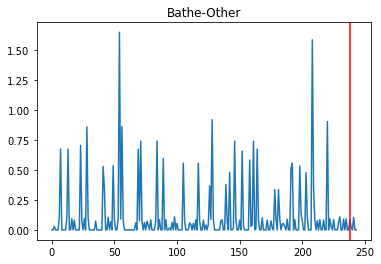

In [11]:
# scores_list = cpd_calculate(episodes, dataset, sensors, algorithm, True)

scores_list = []

for index in range(len(episodes)):

    if index<55:
        continue

    episode, transition, label = episodes[index], transitions[index], labels[index]

    features = np.array(feature_extraction(episode, dataset, sensors))

    scores = np.array(change_point_detection(features, algorithm))
    scores[scores<0]=0
    
    plt.title(label)
    plt.plot(range(len(scores)), scores)
    plt.axvline(transition, color="r")

    break
#     # scores_list.append(scores)

# # np.save(f"./evaluation/{dataset}/scores_list_{algorithm}.npy", scores_list)

In [ ]:
len([item for item in scores if item>0.3])

### evaluation

In [ ]:
threshold = 0.
interval = 10

# scores_list = np.load(f"./evaluation/{dataset}/scores_list_{algorithm}.npy", allow_pickle=True)

tp_rates = []
fp_rates = []

for e in range(len(episodes)):

    episode, transition, label = episodes[e], transitions[e], labels[e]
    scores = scores_list[e]

    tp = tn = fp = fn = 0

    gt_time = float(episode[transition, 2])

    for ee in range(len(episode)):
        event_time = float(episode[ee, 2])
        if scores[ee]>threshold:
            if abs(gt_time-event_time)<interval:
                tp+=1
            else:
                fp+=1
        else:
            if ee==transition:
                fn+=1
            else:
                tn+=1

    assert tp+tn+fp+fn == len(episode)

    tp_rates.append(tp/(tp+fn))
    fp_rates.append(fp/(fp+tn))

sum(tp_rates)/len(tp_rates), sum(fp_rates)/len(fp_rates)